### Описание проекта

Нужно решить, где бурить новую скважину добывающей компании «ГлавРосГосНефть.
Шаги для выбора локации обычно такие:
- В избранном регионе собирают характеристики для скважин: качество нефти и объём её запасов;
- Строят модель для предсказания объёма запасов в новых скважинах;
- Выбирают скважины с самыми высокими оценками значений;
- Определяют регион с максимальной суммарной прибылью отобранных скважин.
- Вам предоставлены пробы нефти в трёх регионах. Характеристики для каждой скважины в регионе уже известны. Постройте модель для определения региона, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой Bootstrap.

Описание данных
- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
- product — объём запасов в скважине (тыс. баррелей).

### Условия задачи:
- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.
- Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.linear_model import LinearRegression #линейная регрессия
from sklearn.model_selection import train_test_split #деление выборки 
from sklearn.metrics import f1_score,roc_curve,roc_auc_score,precision_score, recall_score,precision_recall_curve #подсчет  F1
import matplotlib.pyplot as plt #график
import warnings 
warnings.simplefilter(action='ignore', category=FutureWarning) #убираем ошибку
from sklearn.metrics import mean_squared_error # значение метрики RMSE
from tqdm.notebook import tqdm_notebook
from numpy.random import RandomState
import seaborn as sns

### 1. Загрузка и подготовка данных

#### 1.1 Датасет_2

In [3]:
geo_data_2 = pd.read_csv('/Users/l.stefanenko/Desktop/Yandex/Github/№8 ML_in_business_neft/geo_data_2 (1).csv')

In [4]:
geo_data_2.shape

(100000, 5)

In [5]:
display(geo_data_2.head())

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [6]:
geo_data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [7]:
geo_data_2.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


#### 1.2 Датасет_1

In [8]:
geo_data_1 = pd.read_csv('/Users/l.stefanenko/Desktop/Yandex/Github/№8 ML_in_business_neft/geo_data_1 (1).csv')

In [9]:
display(geo_data_1.head())

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [10]:
geo_data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [11]:
geo_data_1.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


#### 1.3 Датасет_0

In [12]:
geo_data_0 = pd.read_csv('/Users/l.stefanenko/Desktop/Yandex/Github/№8 ML_in_business_neft/geo_data_0 (1).csv')

In [13]:
display(geo_data_0.head())

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [14]:
geo_data_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [15]:
geo_data_0.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


#### Вывод 
Мы видим, что в данных нет пропусков, типы данных нас удовлетворяяют, названия столбцов в нужном формате. Удалим для дальнейшего исследования столбец  ID из каждого датасета

<AxesSubplot:>

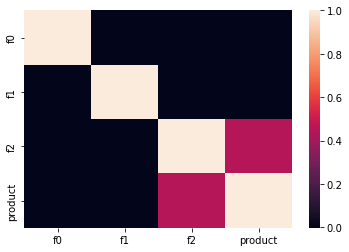

In [16]:
sns.heatmap(geo_data_2.corr())

In [17]:
geo_data_2 = geo_data_2.drop(columns = ['id'],axis = 1) 

<AxesSubplot:>

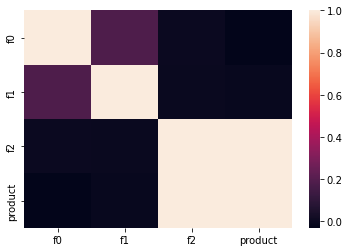

In [18]:
sns.heatmap(geo_data_1.corr())

Высокая  корреляция между f2 и product, удалим столбец f2

In [19]:
geo_data_1 = geo_data_1.drop(columns = ['id'],axis = 1) 

<AxesSubplot:>

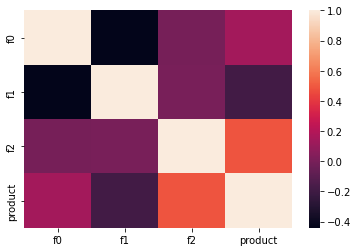

In [20]:
sns.heatmap(geo_data_0.corr())

In [21]:
geo_data_0 = geo_data_0.drop(columns = ['id'],axis = 1) 

### 2. Разбейте данные на обучающую и валидационную выборки в соотношении 75:25

#### 2.1 Разбиение на выборки_Датасет_2

In [22]:
features_2 = geo_data_2.drop (['product'],axis=1)# извлеките признаки 
target_2 = geo_data_2['product'] # извлеките целевой признак

In [23]:
features_train_2, features_valid_2, target_train_2, target_valid_2 = train_test_split(
    features_2,target_2,test_size=0.25, random_state=12345)

In [24]:
print(features_train_2.shape, target_train_2.shape)
print(features_valid_2.shape, target_valid_2.shape)

(75000, 3) (75000,)
(25000, 3) (25000,)


#### 2.2 Разбиение на выборки_Датасет_1

In [25]:
features_1 = geo_data_1.drop (['product'],axis=1)# извлеките признаки 
target_1 = geo_data_1['product'] # извлеките целевой признак

In [26]:
features_train_1, features_valid_1, target_train_1, target_valid_1 = train_test_split(
    features_1,target_1,test_size=0.25, random_state=12345)

In [27]:
print(features_train_1.shape, target_train_1.shape)
print(features_valid_1.shape, target_valid_1.shape)

(75000, 3) (75000,)
(25000, 3) (25000,)


#### 2.3 Разбиение на выборки_Датасет_0

In [28]:
features_0 = geo_data_0.drop (['product'],axis=1)# извлеките признаки 
target_0 = geo_data_0['product'] # извлеките целевой признак

In [29]:
features_train_0, features_valid_0, target_train_0, target_valid_0 = train_test_split(
    features_0,target_0,test_size=0.25, random_state=12345)

In [30]:
print(features_train_0.shape, target_train_0.shape)
print(features_valid_0.shape, target_valid_0.shape)

(75000, 3) (75000,)
(25000, 3) (25000,)


### 3.  Обучите модель линойной регрессии на  каждой выборке и сделайте предсказания на валидационной выборке.

#### 3.1 Обучение модели_Датасет_2

In [31]:
model = LinearRegression() # инициализируйте модель LinearRegression
model.fit(features_train_2,target_train_2) # обучите модель на тренировочной выборке
predictions_valid_2 = model.predict(features_valid_2) # получите предсказания модели на валидационной выборке

result_2 = mean_squared_error(target_valid_2,predictions_valid_2)**0.5# посчитайте значение метрики RMSE на валидационной выборке
print("Средний обьем предсказанного сырья во 2 регионе:", predictions_valid_2.mean())
print("RMSE_2 модели линейной регрессии на валидационной выборке:", result_2)

Средний обьем предсказанного сырья во 2 регионе: 94.96504596800489
RMSE_2 модели линейной регрессии на валидационной выборке: 40.02970873393434


#### 3.2 Обучение модели_Датасет_1

In [32]:
model = LinearRegression() # инициализируйте модель LinearRegression
model.fit(features_train_1,target_train_1) # обучите модель на тренировочной выборке
predictions_valid_1 = model.predict(features_valid_1) # получите предсказания модели на валидационной выборке

result_1 = mean_squared_error (target_valid_1,predictions_valid_1)**0.5# посчитайте значение метрики RMSE на валидационной выборке
print("Средний обьем предсказанного сырья в 1 регионе:", predictions_valid_1.mean())
print("RMSE_1 модели линейной регрессии на валидационной выборке:", result_1)

Средний обьем предсказанного сырья в 1 регионе: 68.72854689544602
RMSE_1 модели линейной регрессии на валидационной выборке: 0.893099286775617


#### 3.3 Обучение модели_Датасет_0

In [33]:
model = LinearRegression() # инициализируйте модель LinearRegression
model.fit(features_train_0,target_train_0) # обучите модель на тренировочной выборке
predictions_valid_0 = model.predict(features_valid_0) # получите предсказания модели на валидационной выборке

result_0 = mean_squared_error (target_valid_0,predictions_valid_0)**0.5# посчитайте значение метрики RMSE на валидационной выборке
print("Средний обьем предсказанного сырья в 0 регионе:", predictions_valid_0.mean())
print("RMSE_0 модели линейной регрессии на валидационной выборке:", result_0)

Средний обьем предсказанного сырья в 0 регионе: 92.59256778438035
RMSE_0 модели линейной регрессии на валидационной выборке: 37.5794217150813


In [34]:
table_result = pd.DataFrame(
  columns=['Средний обьем сырья', '|',
             'RMSE',  '|',
            ],
    
    index=['Скважина_0',
           'Скважина_1',
           'Скважина_2'])


table_result['|'] =  '|'

In [35]:
table_result.loc['Скважина_0','Средний обьем сырья'] = predictions_valid_0.mean()
table_result.loc['Скважина_0','RMSE'] = result_0

In [36]:
table_result.loc['Скважина_1','Средний обьем сырья'] = predictions_valid_1.mean()
table_result.loc['Скважина_1','RMSE'] = result_1

In [37]:
table_result.loc['Скважина_2','Средний обьем сырья'] = predictions_valid_2.mean()
table_result.loc['Скважина_2','RMSE'] = result_2

In [38]:
display(table_result)

,Средний обьем сырья,|,RMSE,|
Скважина_0,92.592568,|,37.579422,|
Скважина_1,68.728547,|,0.893099,|
Скважина_2,94.965046,|,40.029709,|


### Вывод: 
Как видно из полученных данных, для Регионов 0 и 2 показатели средний объем запасов и квадратный корень из средней квадратичной ошибки RMSE очень близки. 

При этом для Региона 1 показатель RMSE меньше единицы, что более чем в 40 раз меньше аналогичного показателя для Регионов 0 и 2 - это говорит о более точных предсказаниях модели для Региона 1. Такая точность скорее всего вызвана прямой корреляцией параметра `f2` и объема запасов в регионе `product`, а также выбранным алгоритмом обучения с помощью линейной регрессии.Самый большой средний запас сырья (94,9 тыс.бареллей) во 2 регионе 

### 4.Расчет достаточного объёма сырья для безубыточной разработки новой скважины

#### Условие:
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. 
- Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.

In [39]:
BUDGET = 10*1e+9
COUNT_HOLE = 500
BEST_HOLE = 200
PROFIT_ONE_HOLE = 450*1e+3
MIN_FUEL_ONE_HOLE = BUDGET / (BEST_HOLE * PROFIT_ONE_HOLE)

print("Минимальное кол-во топлива, необходимого в скважине для выхода в 0:",MIN_FUEL_ONE_HOLE)

Минимальное кол-во топлива, необходимого в скважине для выхода в 0: 111.11111111111111


### Вывод
Среднее количество топлива на одной скажины, необходимое для полного освоения бюджета (выход в 0) - 111 т.баррелей. Это больше чем средний запас предсказанного сырья по валидационной выборке по регионам.  Максимальный запас сырья (94,9 тыс.бареллей) во 2 регионе меньше требуемых 111 тыс.бареллей

### 5.Расчет прибыли и рисков

Сброс индексов и перевод в Series

In [40]:
target_valid_2 = target_valid_2.reset_index()
target_valid_2= target_valid_2['product']
target_valid_1 = target_valid_1.reset_index()
target_valid_1= target_valid_1['product']
target_valid_0 = target_valid_0.reset_index()
target_valid_0= target_valid_0['product']

In [41]:
predictions_valid_2 = pd.Series (predictions_valid_2)
predictions_valid_1 = pd.Series (predictions_valid_1)
predictions_valid_0 = pd.Series (predictions_valid_0)

In [42]:
def get_profit(predict, valid, count):
    """функция берет значение самых богатых скважин и высчитывает прибыль"""
     #сортируем по возрастанию
    predict_sort = predict.sort_values(ascending=False)
   
    # отбираем из валид.выборки по индексам отсортированного предсказания и берем count скважин
    valid_sort = valid[predict_sort.index][:count]
    
    # общее кол-во топлива
    total_fuel = valid_sort.sum()
    
    # считаем прибиль: запасы топлива всех скважин * прибыль с топлива - бюджет
    profit = total_fuel * PROFIT_ONE_HOLE - BUDGET
 
    return profit

In [43]:
print("Прибыль с лучших скважин во 2 регионе :",round(get_profit(predictions_valid_2, target_valid_2, BEST_HOLE)/1e+6), 'млн.')
print("Прибыль с лучших скважин в 1 регионе :",round(get_profit(predictions_valid_1, target_valid_1, BEST_HOLE)/1e+6), 'млн.')
print("Прибыль с лучших скважин в 0 регионе :",round(get_profit(predictions_valid_0, target_valid_0, BEST_HOLE)/1e+6), 'млн.')

Прибыль с лучших скважин во 2 регионе : 2710 млн.
Прибыль с лучших скважин в 1 регионе : 2415 млн.
Прибыль с лучших скважин в 0 регионе : 3321 млн.


In [44]:
def get_top_fuel(predict, valid, count):
    #сортируем по возрастанию
    predict_sort = predict.sort_values(ascending=False)

    # отбираем из валид.выборки по индексам отсортированного предсказания и берем count скважин
    valid_sort = valid[predict_sort.index][:count]
    
    # общее кол-во топлива
    total_fuel = valid_sort.sum()
 
    return total_fuel

In [45]:
print('======общее кол-во топлива с лучших скважин по регионам=======')

print("общее кол-во топлива с лучших скважин во 2 регионе,тыс.бар.:",round(get_top_fuel(predictions_valid_2, target_valid_2, BEST_HOLE)))
print("общее кол-во топлива с лучших скважин во 1 регионе,тыс.бар.:",round(get_top_fuel(predictions_valid_1, target_valid_1, BEST_HOLE)))
print("общее кол-во топлива с лучших скважин во 0 регионе,тыс.бар.:",round(get_top_fuel(predictions_valid_0, target_valid_0, BEST_HOLE)))

======общее кол-во топлива с лучших скважин по регионам=======
общее кол-во топлива с лучших скважин во 2 регионе,тыс.бар.: 28245
общее кол-во топлива с лучших скважин во 1 регионе,тыс.бар.: 27589
общее кол-во топлива с лучших скважин во 0 регионе,тыс.бар.: 29602


В результате анализа мы видим, что из каждого региона возможность добыть количество баррелей нефти из лучших скважин значительно выше точки безубыточность (111тыс. баррелей)

#### 5.1 Бутстреп

In [46]:
state = np.random.RandomState(12345)

In [47]:
def boot_fuel(predict, valid, repeat):
    """функция с помощью техники бутстреп отбирает средние значения из лучших скважин из случайных"""
    values = []
    alpha = 0.05

    # бутстреп
    for _ in tqdm_notebook(range(repeat)):
        predict_sample = predict.sample(n=COUNT_HOLE, random_state=state, replace=True)
        valid_sample = valid[predict_sample.index]
        # расчет прибыли
        result = get_profit(predict_sample, valid_sample, BEST_HOLE)
        values.append(result)

    values = pd.Series(values)

    # доверительный интервал в 95%
    lower = round( values.quantile(alpha/2) / 1e+6 ) # 2.5% снизу
    upper = round( values.quantile(1-alpha/2) / 1e+6 ) # 2,5% сверху

    #считаем шанс получить отрицательную прибыль 
    risk = (values<0).mean()*100

    print(
        f'Средняя прибыль: {round(values.mean()/1e+6)} млн.\n95% интервал:{(lower, upper,)} млн.\nриск убытков:{round(risk,2)}%'
    )


In [48]:
boot_fuel(predictions_valid_2, target_valid_2, 500)
boot_fuel(predictions_valid_1, target_valid_1, 500)
boot_fuel(predictions_valid_0, target_valid_0, 500)

  0%|          | 0/500 [00:00<?, ?it/s]

Средняя прибыль: 436 млн.
95% интервал:(-134, 967) млн.
риск убытков:7.2%


  0%|          | 0/500 [00:00<?, ?it/s]

Средняя прибыль: 515 млн.
95% интервал:(85, 932) млн.
риск убытков:0.8%


  0%|          | 0/500 [00:00<?, ?it/s]

Средняя прибыль: 423 млн.
95% интервал:(-128, 942) млн.
риск убытков:6.2%


### Вывод
Для дальнейшей разработки месторождений рекомендуется использовать 1 регион. Ожидаемая прибыль 515 млн, риски минимальные  (меньше одного процента)